# Unsupervised Anomali Detection

This is inspired by [alexisbcook
/ResNetCAM-keras](https://github.com/alexisbcook/ResNetCAM-keras)

Below, you can find the ability of a pretrained model ResNet50 as an extension of the [paper](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf). The main idea is that each of the activation maps in the final layer preceding the GAP layer acts as a detector for a different pattern in the image, localized in space. 
The main difference of ResNet50 and VGG19 (used later) is that trainable parameters are not located in the fully connected layers at the top of the network.

In [97]:
import numpy as np
import ast
import scipy   
import matplotlib.pyplot as plt
import cv2   
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image    
from keras.models import Model   
import sys
import os
import torch
from torch import nn
from torchvision import datasets, transforms, models
from PIL import Image
import pickle



from vgg19 import VGG19

In [64]:
def pretrained_path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    x = np.expand_dims(x, axis=0)
    # convert RGB -> BGR, subtract mean ImageNet pixel, and return 4D tensor
    return preprocess_input(x)

In [65]:
def get_ResNet():
    # define ResNet50 model
    model = ResNet50(weights='imagenet')
    # get AMP layer weights
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    # extract wanted output
    ResNet_model = Model(inputs=model.input, 
        outputs=(model.layers[-4].output, model.layers[-1].output)) 
    return ResNet_model, all_amp_layer_weights

In [66]:
def ResNet_CAM(img_path, model, all_amp_layer_weights):
    # get filtered images from convolutional output + model prediction vector
    last_conv_output, pred_vec = model.predict(pretrained_path_to_tensor(img_path))
    # change dimensions of last convolutional outpu tto 7 x 7 x 2048
    last_conv_output = np.squeeze(last_conv_output) 
    # get model's prediction (number between 0 and 999, inclusive)
    pred = np.argmax(pred_vec)
    # bilinear upsampling to resize each filtered image to size of original image 
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # dim: 224 x 224 x 2048
    # get AMP layer weights
    amp_layer_weights = all_amp_layer_weights[:, pred] # dim: (2048,) 
    # get class activation map for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult.reshape((224*224, 2048)), amp_layer_weights).reshape(224,224) # dim: 224 x 224
    # return class activation map
    return final_output, pred

In [67]:
def plot_ResNet_CAM(img_path, ax, model, all_amp_layer_weights):
    # load image, convert BGR --> RGB, resize image to 224 x 224,
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224))
    # plot image
    ax.imshow(im, alpha=0.5)
    # get class activation map
    CAM, pred = ResNet_CAM(img_path, model, all_amp_layer_weights)
    # plot class activation map
    ax.imshow(CAM, cmap='jet', alpha=0.5)
    # load the dictionary that identifies each ImageNet category to an index in the prediction vector
    with open('C:/Users/pgyaf/OneDrive/Desktop/ExtendAI/ResNetCAM-keras/imagenet1000_clsid_to_human.txt') as imagenet_classes_file:
        imagenet_classes_dict = ast.literal_eval(imagenet_classes_file.read())
    # obtain the predicted ImageNet category
    ax.set_title(imagenet_classes_dict[pred])    

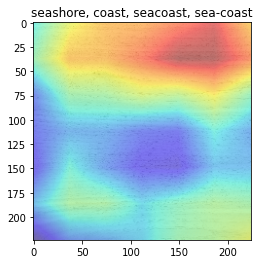

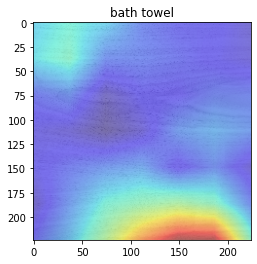

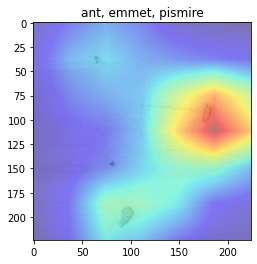

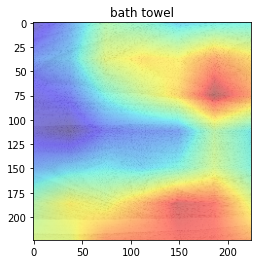

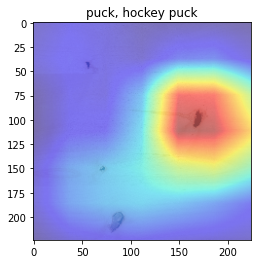

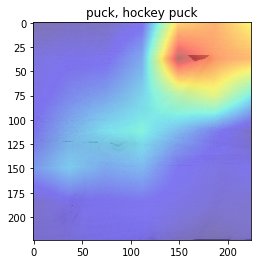

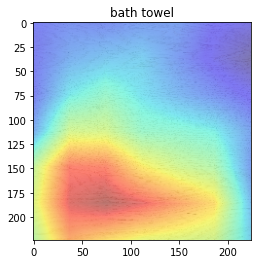

In [68]:
ResNet_model, all_amp_layer_weights = get_ResNet()
directory="C:/Users/pgyaf/OneDrive/Desktop/ExtendAI/extend-ai-ml-assessment/data/New folder"
for filename in os.listdir(directory):
    fig, ax = plt.subplots()
    f = os.path.join(directory, filename)
    img_path = f
    CAM = plot_ResNet_CAM(img_path, ax, ResNet_model, all_amp_layer_weights)
    plt.show()

**Auto encoding**

image height: 2592
image width: 1952


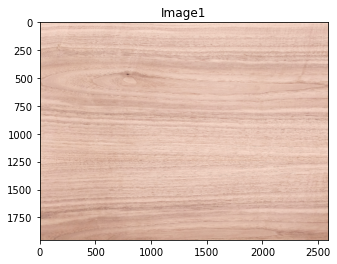

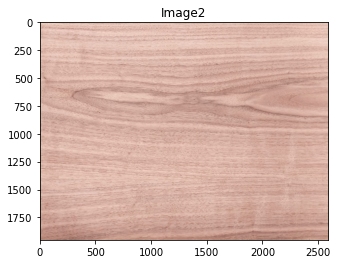

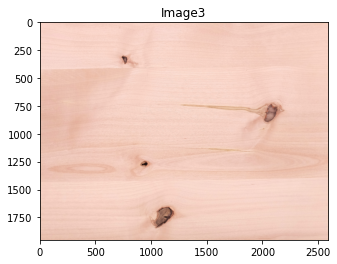

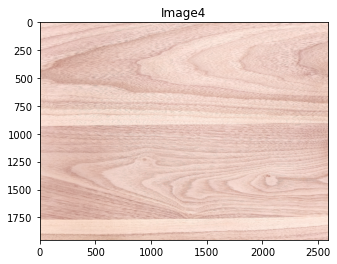

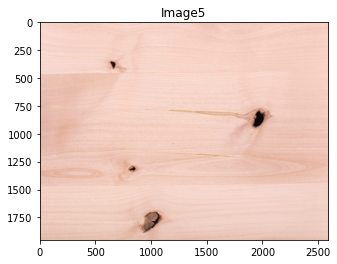

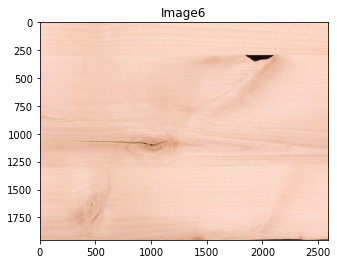

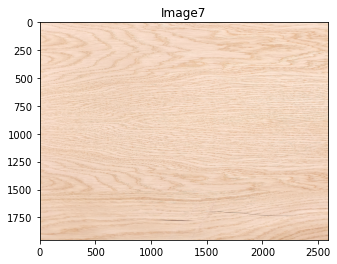

In [107]:
h,w = dataset[0][0].size
print("image height:", h)
print("image width:", w)

   
for i in range(len(dataset)):
    plt.figure(i+1)
    plt.imshow(dataset[i][0])
    plt.title(f'Image{i+1}')

**The code cells below use intact images (without anomali) as a train dataset to reconstruct the image based on them. The remained images with anomalies and defects were used as test dataset.**

In [108]:
dataset = datasets.ImageFolder('C:/Users/pgyaf/OneDrive/Desktop/ExtendAI/extend-ai-ml-assessment/data')
dataset

Dataset ImageFolder
    Number of datapoints: 7
    Root location: C:/Users/pgyaf/OneDrive/Desktop/ExtendAI/extend-ai-ml-assessment/data

**An autoencoder model was utulized to determin the defect through comparing the intact images with others (anomali images).
Feature map of the first layer of the VGG19 is the input to the autoencoder model.The network is trained using intact images. A horizental and vertical random flip and gaussian noise for image augmentation.**



In [145]:
class NN(nn.Module):
    def __init__(self,device):
        super().__init__()

        self.feature = VGG19().to(device)
        self.upsample = 'nearest'
        self.device = device
        self.input_dim = 64
        self.latent_dim = 32
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=self.input_dim, out_channels=self.latent_dim, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=self.latent_dim),
            nn.ReLU(), # Activation function
            
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.latent_dim, out_channels=self.input_dim, kernel_size=3, stride=2, output_padding=1),
            nn.BatchNorm2d(num_features=self.input_dim),
            nn.ReLU()
        )
    
    def forward(self,x):
        B,C,H,W = x.shape
        x = self.feature(x,'relu1_1')
        features = torch.Tensor().to(self.device)
        for k,feat_map in x.items():
            feat_map = nn.functional.interpolate(feat_map, size=(H,W), mode='nearest', align_corners=True if self.upsample == 'bilinear' else None)
            features = torch.cat([features, feat_map], dim=1)
        x = self.encoder(features)
        x = self.decoder(x)
        return features, x
        
    
    

In [ ]:
Preprocess = transforms.Compose([
                transforms.RandomCrop(size=(256, 256)),
                transforms.RandomHorizontalFlip(.5),
                transforms.RandomVerticalFlip(.5),
                transforms.GaussianBlur(kernel_size=(3,3)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])])

In [146]:
def train(model,dataloder,device,lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    for data,_ in dataloader:
        data = data.to(device=device)
        model.zero_grad()
        features, pred = model(data)
        loss = criterion(pred, features)
        loss.backward()
        optimizer.step()
        total_loss += loss
    return total_loss

In [147]:
def evaluation(model,dataset,device,preprocess):
    for data,_ in dataset:
        input_img = data
        data = preprocess(data).unsqueeze(0)
        features, output = model.forward(data.to(device=device))
        output_img = (output-features).norm(dim=(1),keepdim=True)[0,0]
        output_img = output_img.detach().cpu().numpy()
        output_img = (output_img-np.min(output_img))/np.ptp(output_img)
#         output_img = (output_img)/output_img.max()
        threshold = .05
        output_img[output_img<threshold] = 0
        output_img[output_img>threshold] = 1
        output_img = Image.fromarray(np.uint8(output_img*255)).convert('P')
        fig = plt.figure(figsize=(20,10))
        ax1 = fig.add_subplot(1,2,1)
        ax1.set_title('Original Image')
        ax1.imshow(input_img)
        fig = plt.figure(figsize=(20,10))
        ax2 = fig.add_subplot(1,2,2)
        ax2.set_title('Reconstructed Image')
        ax2.imshow(output_img,cmap = plt.get_cmap(name = 'gray'))
        plt.show()
        
        
        

In [150]:
train_ = './data_train/'
lr = 0.001
epoch = 1000

train_set = datasets.ImageFolder(train_,transform=Preprocess)

device = 'cpu'

model = NN(device=device)
model = model.to(device=device)
dataloader = torch.utils.data.DataLoader(train_set,batch_size=4)

for e in range(epoch):
    epoch_loss = 0
    model.train()
    loss = train(model,dataloader,device,lr)
    epoch_loss += loss
    print(f'epoch {e} loss: {epoch_loss}')

filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

epoch 0 loss: 85.3890380859375
epoch 1 loss: 78.27001953125
epoch 2 loss: 76.92608642578125
epoch 3 loss: 77.58543395996094
epoch 4 loss: 78.61524963378906
epoch 5 loss: 72.93670654296875
epoch 6 loss: 83.01026916503906
epoch 7 loss: 76.2326889038086
epoch 8 loss: 76.21047973632812
epoch 9 loss: 76.2870101928711
epoch 10 loss: 73.053466796875
epoch 11 loss: 71.6527099609375
epoch 12 loss: 76.65620422363281
epoch 13 loss: 71.32144927978516
epoch 14 loss: 71.42942810058594
epoch 15 loss: 71.87594604492188
epoch 16 loss: 72.95999908447266
epoch 17 loss: 72.8416519165039
epoch 18 loss: 74.41899871826172
epoch 19 loss: 70.81543731689453
epoch 20 loss: 77.7777328491211
epoch 21 loss: 76.55754089355469
epoch 22 loss: 74.20555114746094
epoch 23 loss: 71.10566711425781
epoch 24 loss: 72.425537109375
epoch 25 loss: 73.30696105957031
epoch 26 loss: 72.48131561279297
epoch 27 loss: 75.29985046386719
epoch 28 loss: 73.580078125
epoch 29 loss: 73.69346618652344
epoch 30 loss: 70.50578308105469
epoch

epoch 247 loss: 71.19437408447266
epoch 248 loss: 70.08551788330078
epoch 249 loss: 68.38814544677734
epoch 250 loss: 69.55213165283203
epoch 251 loss: 69.57933044433594
epoch 252 loss: 72.35199737548828
epoch 253 loss: 75.64285278320312
epoch 254 loss: 67.85301208496094
epoch 255 loss: 69.8136978149414
epoch 256 loss: 67.78699493408203
epoch 257 loss: 68.57305908203125
epoch 258 loss: 66.62937927246094
epoch 259 loss: 69.55702209472656
epoch 260 loss: 68.53355407714844
epoch 261 loss: 67.39376068115234
epoch 262 loss: 68.1241683959961
epoch 263 loss: 67.24848937988281
epoch 264 loss: 68.0422134399414
epoch 265 loss: 66.9613265991211
epoch 266 loss: 68.38423156738281
epoch 267 loss: 73.51282501220703
epoch 268 loss: 75.22299194335938
epoch 269 loss: 66.72416687011719
epoch 270 loss: 69.218994140625
epoch 271 loss: 67.87403869628906
epoch 272 loss: 68.68682098388672
epoch 273 loss: 69.42024230957031
epoch 274 loss: 70.44560241699219
epoch 275 loss: 73.8583755493164
epoch 276 loss: 70.37

epoch 491 loss: 70.13447570800781
epoch 492 loss: 67.89227294921875
epoch 493 loss: 65.73387145996094
epoch 494 loss: 66.83114624023438
epoch 495 loss: 71.0064926147461
epoch 496 loss: 67.28276062011719
epoch 497 loss: 67.65607452392578
epoch 498 loss: 68.40202331542969
epoch 499 loss: 71.26249694824219
epoch 500 loss: 66.93366241455078
epoch 501 loss: 67.23638916015625
epoch 502 loss: 68.84471130371094
epoch 503 loss: 68.56526947021484
epoch 504 loss: 67.703125
epoch 505 loss: 69.28460693359375
epoch 506 loss: 68.73706817626953
epoch 507 loss: 68.2557373046875
epoch 508 loss: 66.16985321044922
epoch 509 loss: 67.4027328491211
epoch 510 loss: 67.78230285644531
epoch 511 loss: 67.01133728027344
epoch 512 loss: 71.75377655029297
epoch 513 loss: 72.2981185913086
epoch 514 loss: 66.92291259765625
epoch 515 loss: 65.54020690917969
epoch 516 loss: 65.7446060180664
epoch 517 loss: 68.08454895019531
epoch 518 loss: 66.6705093383789
epoch 519 loss: 69.59716033935547
epoch 520 loss: 66.816894531

epoch 735 loss: 66.12353515625
epoch 736 loss: 66.44061279296875
epoch 737 loss: 67.20291137695312
epoch 738 loss: 65.82806396484375
epoch 739 loss: 68.94242095947266
epoch 740 loss: 70.02422332763672
epoch 741 loss: 70.40139770507812
epoch 742 loss: 68.33393859863281
epoch 743 loss: 66.32028198242188
epoch 744 loss: 66.48115539550781
epoch 745 loss: 65.07572937011719
epoch 746 loss: 67.92595672607422
epoch 747 loss: 66.11924743652344
epoch 748 loss: 69.94124603271484
epoch 749 loss: 66.07308959960938
epoch 750 loss: 68.36885070800781
epoch 751 loss: 74.21813201904297
epoch 752 loss: 68.02362060546875
epoch 753 loss: 65.45494079589844
epoch 754 loss: 69.77764892578125
epoch 755 loss: 69.43792724609375
epoch 756 loss: 68.03515625
epoch 757 loss: 68.7340087890625
epoch 758 loss: 67.64944458007812
epoch 759 loss: 64.47743225097656
epoch 760 loss: 71.03253936767578
epoch 761 loss: 65.09303283691406
epoch 762 loss: 66.65889739990234
epoch 763 loss: 66.84458923339844
epoch 764 loss: 65.09573

epoch 978 loss: 63.89199447631836
epoch 979 loss: 68.76158142089844
epoch 980 loss: 68.07245635986328
epoch 981 loss: 67.68101501464844
epoch 982 loss: 65.73461151123047
epoch 983 loss: 69.9675521850586
epoch 984 loss: 67.43134307861328
epoch 985 loss: 68.01066589355469
epoch 986 loss: 64.92608642578125
epoch 987 loss: 63.92402648925781
epoch 988 loss: 64.93528747558594
epoch 989 loss: 66.53958892822266
epoch 990 loss: 65.84063720703125
epoch 991 loss: 71.82516479492188
epoch 992 loss: 67.10025024414062
epoch 993 loss: 65.17216491699219
epoch 994 loss: 66.97268676757812
epoch 995 loss: 65.94173431396484
epoch 996 loss: 67.93962097167969
epoch 997 loss: 67.92605590820312
epoch 998 loss: 72.0159912109375
epoch 999 loss: 65.27249908447266


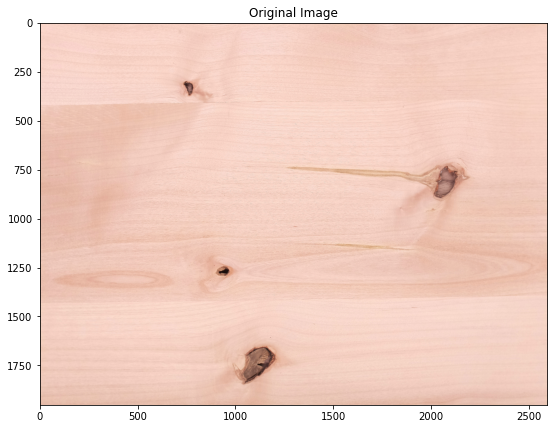

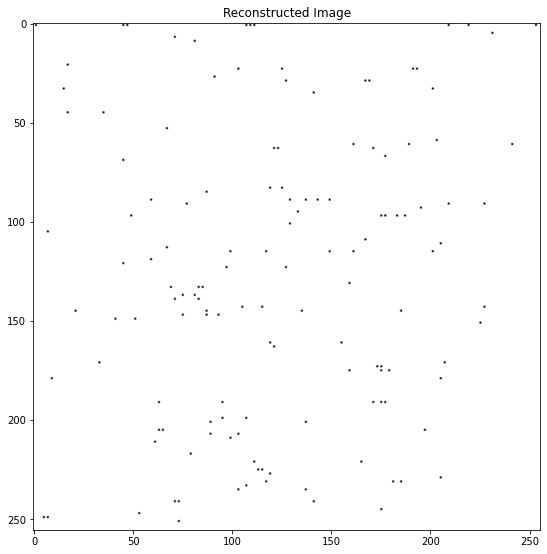

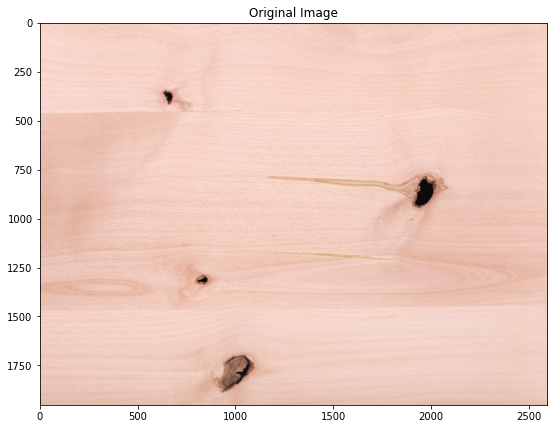

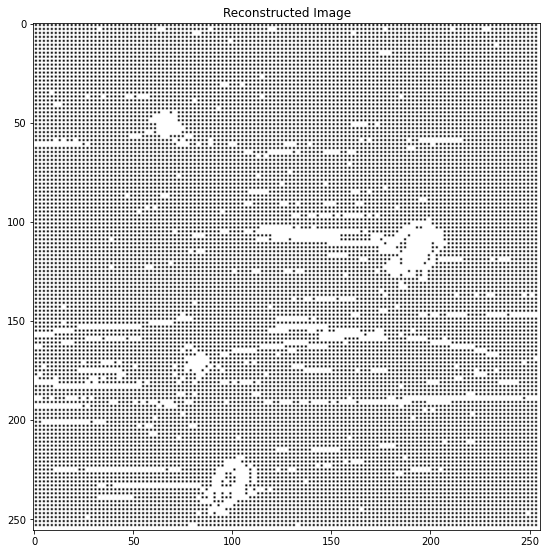

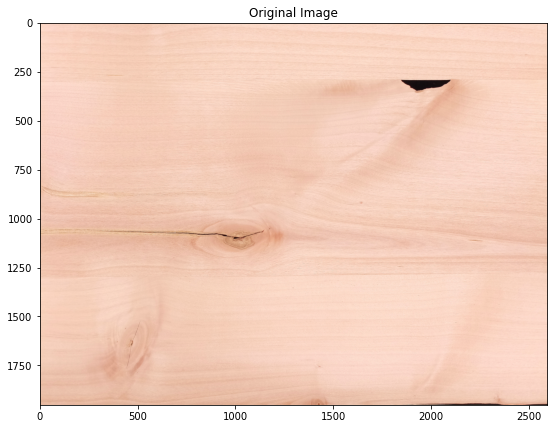

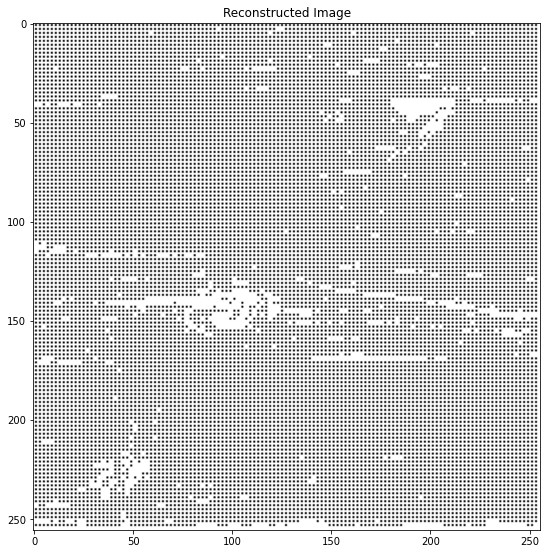

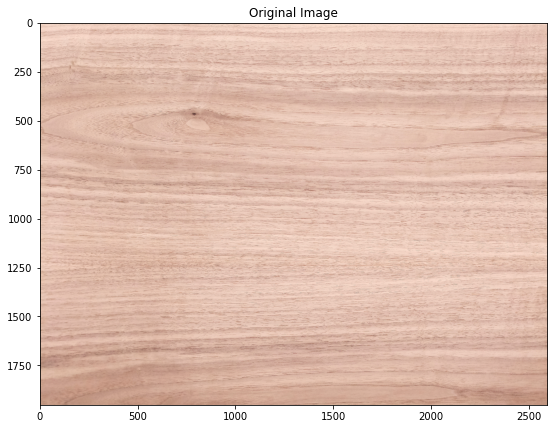

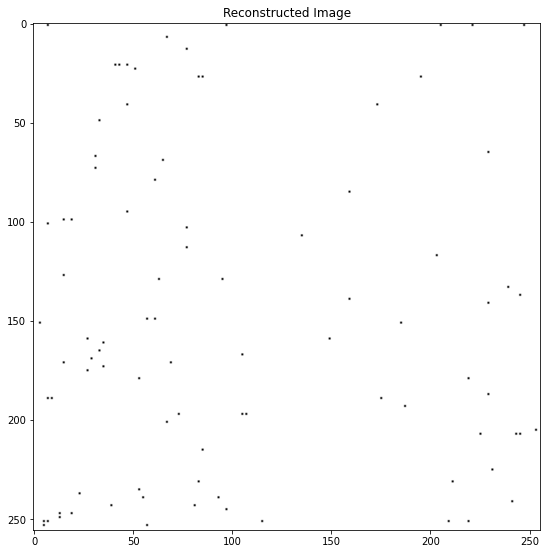

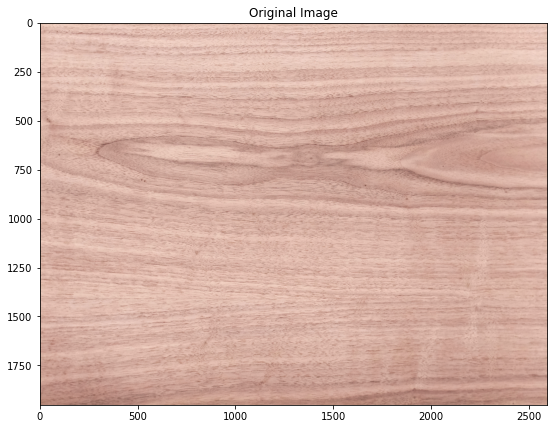

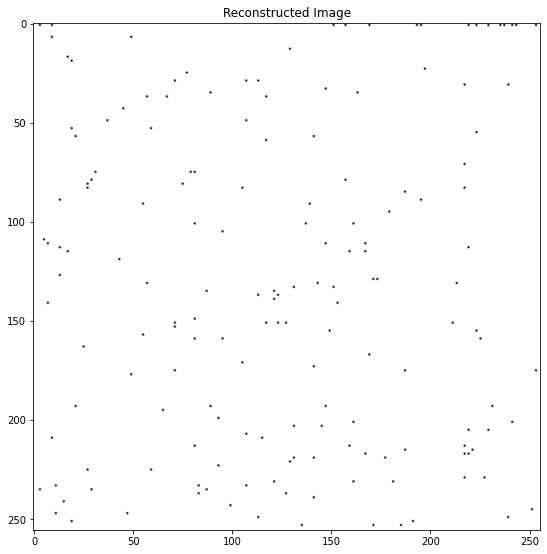

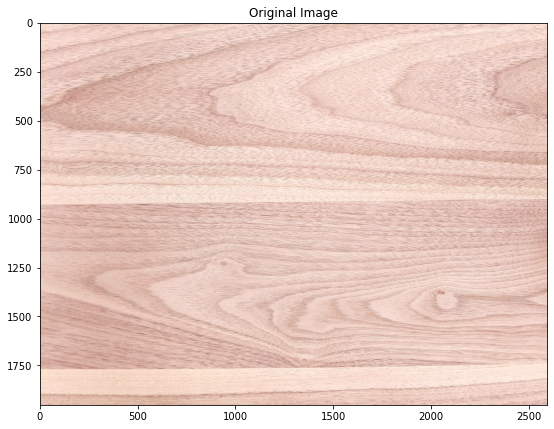

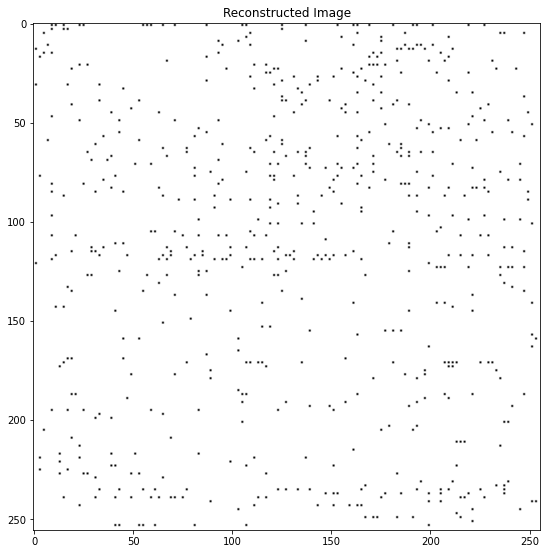

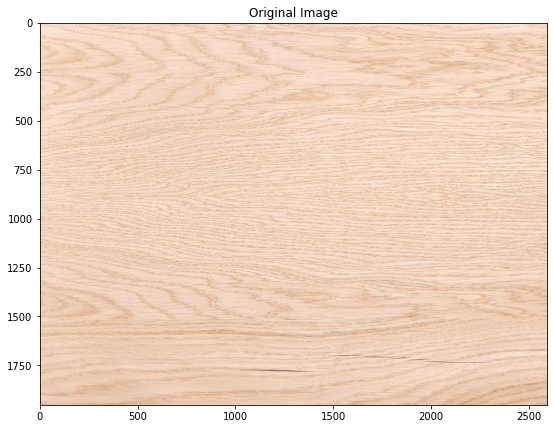

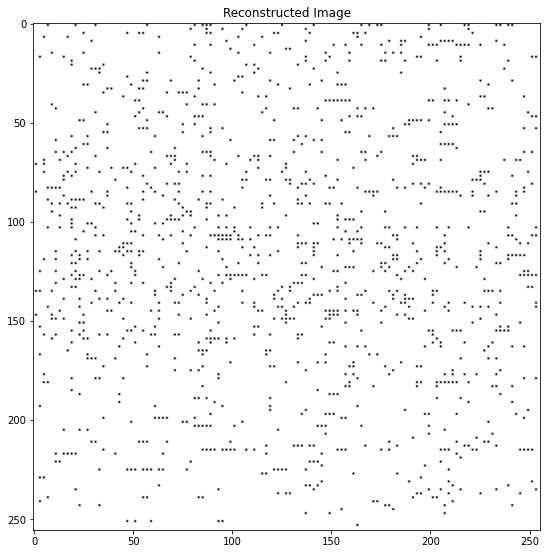

In [151]:
model = pickle.load(open(filename, 'rb'))


test_root = './data_test'
Preprocess_test = transforms.Compose([
                    transforms.Resize(size=(256,256)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
])

test_set = datasets.ImageFolder(test_root)
eval_set = datasets.ImageFolder(train_root)
model.eval()
evaluation(model,test_set,device,Preprocess_test)
evaluation(model,eval_set,device,Preprocess_test)

The main challenge of this model is limite dataset which decreases the redundancy of the model; as you can see it recontruct wood patterns when there are no anomalies. Increasing the number of dataset and employing transfer learning could improve the model aperformance in detecting the actual anomalies and not the wood texture.